In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import yfinance as yf

plt.style.use('fivethirtyeight')

In [173]:
stock = 'AAPL'
num_days = 1000
start_date = (datetime.datetime.now() - datetime.timedelta(days=num_days)).strftime("%Y-%m-%d")
end_date = datetime.datetime.now().strftime("%Y-%m-%d")
df = yf.Ticker(stock).history(start=start_date, end=end_date)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 689 entries, 2021-04-05 00:00:00-04:00 to 2023-12-27 00:00:00-05:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          689 non-null    float64
 1   High          689 non-null    float64
 2   Low           689 non-null    float64
 3   Close         689 non-null    float64
 4   Volume        689 non-null    int64  
 5   Dividends     689 non-null    float64
 6   Stock Splits  689 non-null    float64
dtypes: float64(6), int64(1)
memory usage: 43.1 KB


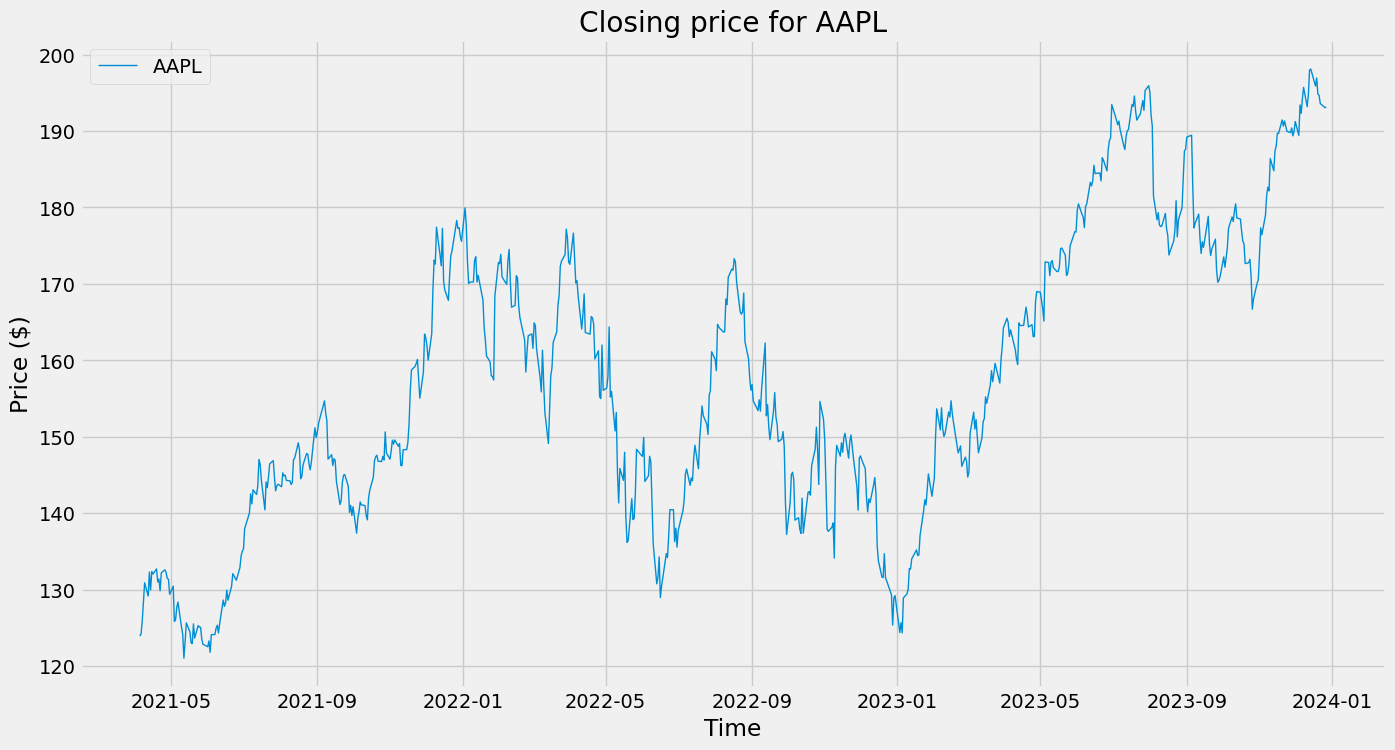

In [174]:
plt.figure(figsize=(15, 8))
plt.plot(df.Close, linewidth=1, label=stock)
plt.xlabel('Time')
plt.ylabel('Price ($)')
plt.title(f'Closing price for {stock}')
plt.legend()
plt.show()

In [175]:
data = pd.DataFrame()
data['Close'] = df.Close
data.head()

,Close
Date,
2021-04-05 00:00:00-04:00,123.899940
2021-04-06 00:00:00-04:00,124.205009
2021-04-07 00:00:00-04:00,125.868172
2021-04-08 00:00:00-04:00,128.289078
2021-04-09 00:00:00-04:00,130.887131


In [176]:
def MACD(data, fast, slow, signal):
    macd = data['Close'].ewm(span=fast).mean() - data['Close'].ewm(span=slow).mean()
    signal = macd.ewm(span=signal).mean()

    return macd, signal

In [177]:
def signals(data):
    buy_price = []
    sell_price = []
    open_position = []
    funds = [100000] * len(data)
    flag = 0
    macd, signal = MACD(data, 12, 26, 9)
    for i in range(len(data)):
        if macd[i] - signal[i] > 0:
            if flag == 0 or flag == -1:
                flag = 1
                buy_price.append(data['Close'][i])
                sell_price.append(np.nan)
                last_pos = funds[i-1]/data['Close'][i]
                funds[i] = funds[i-1]
                open_position.append(last_pos)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                funds[i] = (1 + (data['Close'][i]/data['Close'][i-1] - 1)) * funds[i-1]
                open_position.append(last_pos)
        elif macd[i] - signal[i] < 0:
            if flag == 0 or flag == 1:
                flag = -1
                buy_price.append(np.nan)
                sell_price.append(data['Close'][i])
                last_pos = funds[i-1]/data['Close'][i]
                funds[i] = funds[i-1]
                open_position.append(-last_pos)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                funds[i] = (1 + (1 - data['Close'][i]/data['Close'][i-1])) * funds[i-1]
                open_position.append(-last_pos)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            open_position.append(0)

    return buy_price, sell_price, open_position, funds, macd, signal

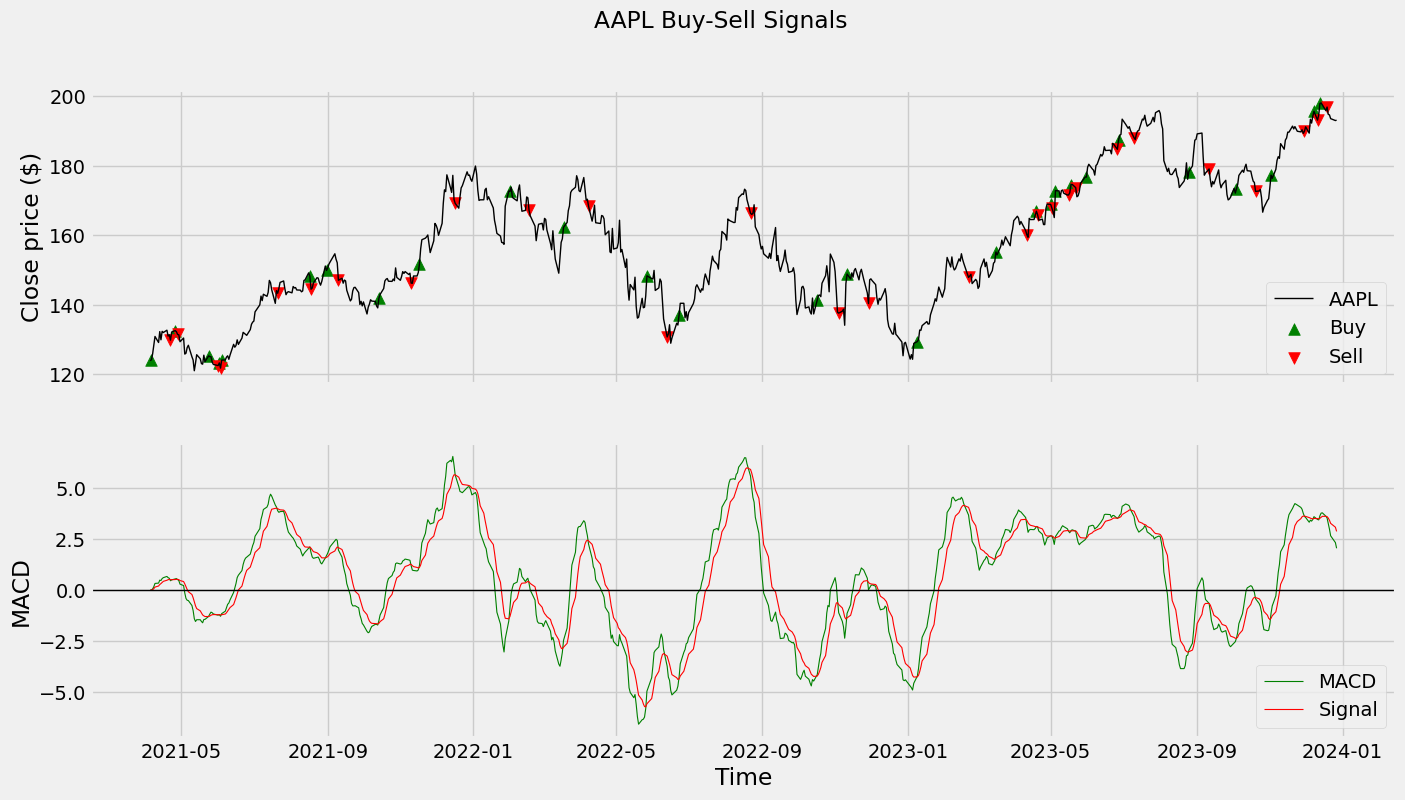

In [178]:
buy_sell = signals(data)
data['Buy price'] = buy_sell[0]
data['Sell price'] = buy_sell[1]
data['Open position'] = buy_sell[2]
data['Live position'] = data['Close'].multiply(data['Open position'])
data['Funds'] = buy_sell[3]
data['MACD'] = buy_sell[4]
data['Signal'] = buy_sell[5]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

ax1.plot(data['Close'], label=stock, linewidth=1, color='black')
ax1.scatter(data.index, data['Buy price'], label='Buy', marker='^', color='green', s=70)
ax1.scatter(data.index, data['Sell price'], label='Sell', marker='v', color='red', s=70)
ax1.set_ylabel('Close price ($)')
ax1.legend(loc='lower right')

ax2.plot(data['MACD'], label='MACD', linewidth=0.8, color='green')
ax2.plot(data['Signal'], label='Signal', linewidth=0.8, color='red')
ax2.set_ylabel('MACD')
ax2.axhline(0, color='black', linewidth=1.0)
ax2.legend(loc='lower right')

fig.suptitle(f'{stock} Buy-Sell Signals')
plt.xlabel('Time')
plt.show()

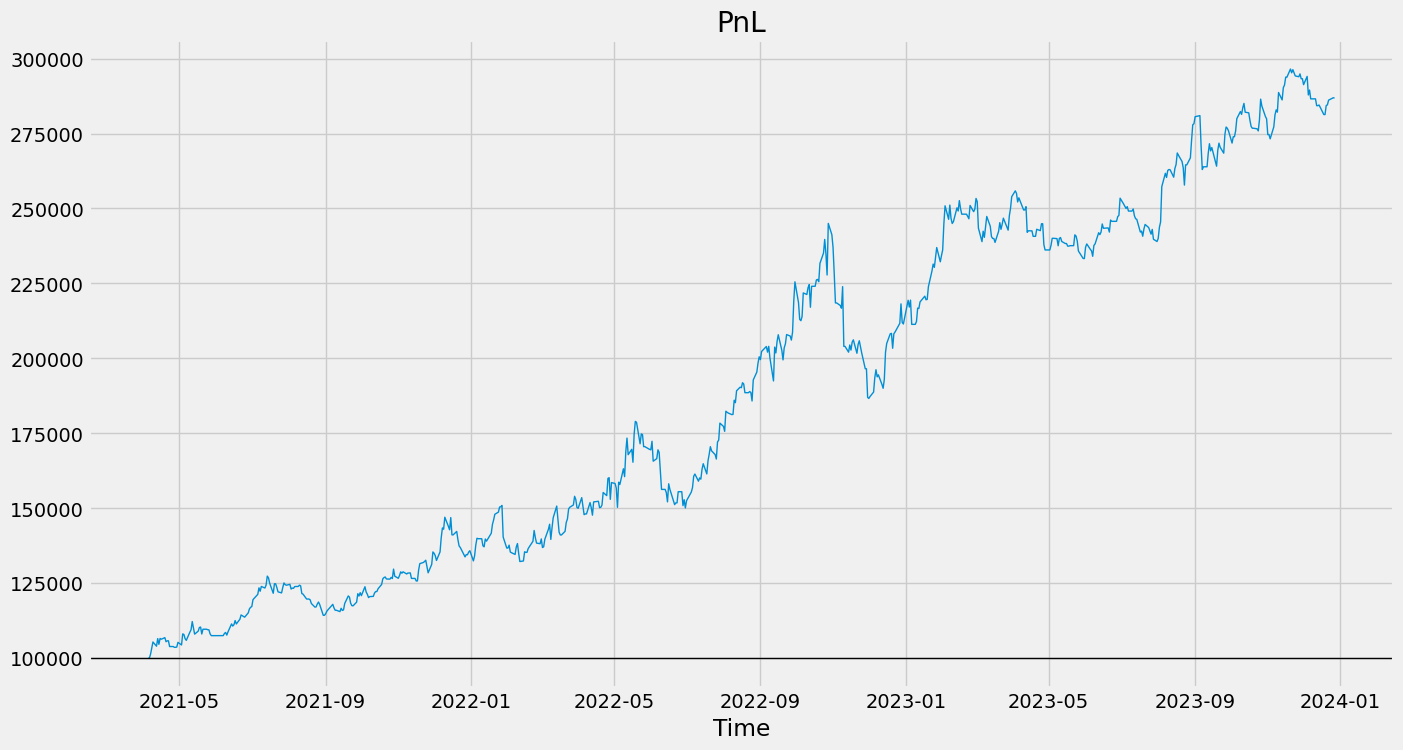

In [179]:
plt.figure(figsize = (15, 8))
plt.plot(data['Funds'], linewidth = 1.0)
plt.axhline(y=data['Funds'][0], color='black', linewidth=1.0)
plt.title('PnL')
plt.xlabel('Time')
plt.show()